In [9]:
import numpy as np
import random

class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []

        for n in self.inputs:
            n.outputs.append(self)
            # set 'self' node as inbound_nodes's outbound_nodes

        self.value = None

        self.gradients = {}
        # keys are the inputs to this node, and their
        # values are the partials of this node with 
        # respect to that input.
        # \partial{node}{input_i}
        

    def forward(self):
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''

        raise NotImplemented
    

    def backward(self):

        raise NotImplemented
        
class Placeholder(Node):
    def __init__(self):
        '''
        An Input node has no inbound nodes.
        So no need to pass anything to the Node instantiator.
        '''
        Node.__init__(self)

    def forward(self, value=None):
        '''
        Only input node is the node where the value may be passed
        as an argument to forward().
        All other node implementations should get the value of the 
        previous node from self.inbound_nodes
        
        Example: 
        val0: self.inbound_nodes[0].value
        '''
        if value is not None:
            self.value = value
            ## It's is input node, when need to forward, this node initiate self's value.

        # Input subclass just holds a value, such as a data feature or a model parameter(weight/bias)
        
    def backward(self):
        self.gradients = {self:0}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
        
        # input N --> N1, N2
        # \partial L / \partial N 
        # ==> \partial L / \partial N1 * \ partial N1 / \partial N


class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)


    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
        ## when execute forward, this node caculate value as defined.

class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):

        # initial a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            # Get the partial of the cost w.r.t this node.
            grad_cost = n.gradients[self]

            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

        # WX + B / W ==> X
        # WX + B / X ==> W

class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x)

    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^-x)
        # y' = 1 / (1 + e^-x) (1 - 1 / (1 + e^-x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.



class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)


    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff


def forward_and_backward(outputnode, graph):
    # execute all the forward method of sorted_nodes.

    ## In practice, it's common to feed in mutiple data example in each forward pass rather than just 1. Because the examples can be processed in parallel. The number of examples is called batch size.
    for n in graph:
        n.forward()
        ## each node execute forward, get self.value based on the topological sort result.

    for n in  graph[::-1]:
        n.backward()

    #return outputnode.value

###   v -->  a -->  C
##    b --> C
##    b --> v -- a --> C
##    v --> v ---> a -- > C

def toplogic(graph):
    sorted_node = []
    
    while len(graph) > 0: 

        all_inputs = []
        all_outputs = []
        
        for n in graph:
            all_inputs += graph[n]
            all_outputs.append(n)
        
        all_inputs = set(all_inputs)
        all_outputs = set(all_outputs)
    
        need_remove = all_outputs - all_inputs  # which in all_inputs but not in all_outputs
    
        if len(need_remove) > 0: 
            node = random.choice(list(need_remove))

            need_to_visited = [node]

            if len(graph) == 1: need_to_visited += graph[node]
                
            graph.pop(node)
            sorted_node += need_to_visited
        
            for _, links in graph.items():
                if node in links: links.remove(node)
        else: # have cycle
            break
        
    return sorted_node

from collections import defaultdict


def convert_feed_dict_to_graph(feed_dict):
    computing_graph = defaultdict(list)
    
    nodes = [n for n in feed_dict]
    
    while nodes:
        n = nodes.pop(0) 
        
        if isinstance(n, Placeholder):
            n.value = feed_dict[n]
        
        if n in computing_graph: continue

        for m in n.outputs:
            computing_graph[n].append(m)
            nodes.append(m)
    
    return computing_graph

def topological_sort_feed_dict(feed_dict):
    graph = convert_feed_dict_to_graph(feed_dict)
    
    return toplogic(graph)


def optimize(trainables, learning_rate=1e-2):
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [10]:
from sklearn.datasets import load_boston

In [11]:
data = load_boston()

In [12]:
losses = []

In [13]:
"""
Check out the new network architecture and dataset!
Notice that the weights and biases are
generated randomly.
No need to change anything, but feel free to tweak
to test your network, play around with the epochs, batch size, etc!
"""

import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Placeholder(), Placeholder()
W1, b1 = Placeholder(), Placeholder()
W2, b2 = Placeholder(), Placeholder()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000
# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort_feed_dict(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

Total number of examples = 506


In [16]:
# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        optimize(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss/steps_per_epoch)

Epoch: 1, Loss: 3.673
Epoch: 101, Loss: 4.226
Epoch: 201, Loss: 5.112
Epoch: 301, Loss: 3.722
Epoch: 401, Loss: 3.553
Epoch: 501, Loss: 4.546
Epoch: 601, Loss: 4.085
Epoch: 701, Loss: 4.430
Epoch: 801, Loss: 4.293
Epoch: 901, Loss: 4.516
Epoch: 1001, Loss: 4.198
Epoch: 1101, Loss: 3.941
Epoch: 1201, Loss: 3.431
Epoch: 1301, Loss: 4.642
Epoch: 1401, Loss: 4.002
Epoch: 1501, Loss: 3.818
Epoch: 1601, Loss: 4.479
Epoch: 1701, Loss: 3.350
Epoch: 1801, Loss: 3.385
Epoch: 1901, Loss: 3.172
Epoch: 2001, Loss: 3.688
Epoch: 2101, Loss: 4.617
Epoch: 2201, Loss: 4.517
Epoch: 2301, Loss: 4.186
Epoch: 2401, Loss: 3.936
Epoch: 2501, Loss: 4.823
Epoch: 2601, Loss: 4.484
Epoch: 2701, Loss: 4.283
Epoch: 2801, Loss: 4.565
Epoch: 2901, Loss: 4.784
Epoch: 3001, Loss: 3.702
Epoch: 3101, Loss: 4.794
Epoch: 3201, Loss: 3.967
Epoch: 3301, Loss: 4.753
Epoch: 3401, Loss: 3.889
Epoch: 3501, Loss: 4.110
Epoch: 3601, Loss: 5.300
Epoch: 3701, Loss: 4.154
Epoch: 3801, Loss: 4.371
Epoch: 3901, Loss: 4.892
Epoch: 4001,

In [18]:
%matplotlib inline

In [19]:
import matplotlib.pyplot as plt

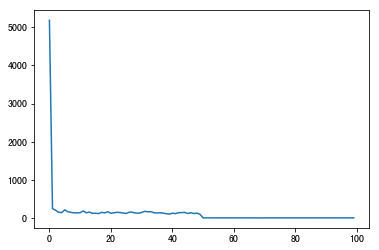

In [20]:
plt.plot(losses)

## 图像如何分类？

In [26]:
import skimage.data
# Reading the image
img = skimage.data.chelsea()
# Converting the image into gray.
gray_img = skimage.color.rgb2gray(img)

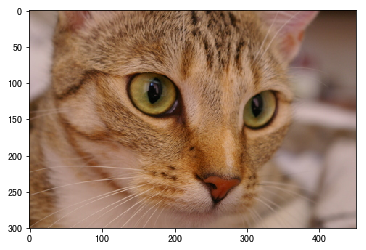

In [25]:
plt.imshow(img)

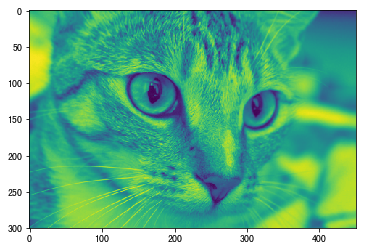

In [27]:
plt.imshow(gray_img)

In [28]:
gray_img

array([[0.48523098, 0.48523098, 0.47738784, ..., 0.11692392, 0.11692392,
        0.11692392],
       [0.49699569, 0.49307412, 0.48523098, ..., 0.12336824, 0.1225349 ,
        0.1272898 ],
       [0.50849255, 0.50457098, 0.49475569, ..., 0.12336039, 0.12728196,
        0.13120353],
       ...,
       [0.24786745, 0.29884784, 0.40501294, ..., 0.58914824, 0.58914824,
        0.58914824],
       [0.38173647, 0.42487373, 0.39628392, ..., 0.57403529, 0.57403529,
        0.57795686],
       [0.42487373, 0.36883294, 0.36042431, ..., 0.55442745, 0.55442745,
        0.55834902]])

In [52]:
l1_filter = np.zeros((2,3,3))

In [53]:
l1_filter[0, :, :] = np.array([[[-1, 0, 1],   
                                   [-1, 0, 1],   
                                   [-1, 0, 1]]])  
l1_filter[1, :, :] = np.array([[[1,   1,  1],   
                                   [0,   0,  0],   
                                   [-1, -1, -1]]]) 

In [46]:
def conv(img, conv_filter):  
    if len(img.shape) > 2 or len(conv_filter.shape) > 3: # Check if number of image channels matches the filter depth.  
        if img.shape[-1] != conv_filter.shape[-1]:  
             print("Error: Number of channels in both image and filter must match.")  
    if conv_filter.shape[1] != conv_filter.shape[2]: # Check if filter dimensions are equal.  
         print('Error: Filter must be a square matrix. I.e. number of rows and columns must match.')  
    if conv_filter.shape[1]%2==0: # Check if filter diemnsions are odd.  
         print('Error: Filter must have an odd size. I.e. number of rows and columns must be odd.')  
            
    feature_maps = np.zeros((img.shape[0]-conv_filter.shape[1]+1,   
                                 img.shape[1]-conv_filter.shape[1]+1,   
                                 conv_filter.shape[0]))  
    
    for filter_num in range(conv_filter.shape[0]):  
        print("Filter ", filter_num + 1)  
        curr_filter = conv_filter[filter_num, :] # getting a filter from the bank.  
        """  
        Checking if there are mutliple channels for the single filter. 
        If so, then each channel will convolve the image. 
        The result of all convolutions are summed to return a single feature map. 
        """  
        if len(curr_filter.shape) > 2:  
            conv_map = conv_(img[:, :, 0], curr_filter[:, :, 0]) # Array holding the sum of all feature maps.  
            for ch_num in range(1, curr_filter.shape[-1]): # Convolving each channel with the image and summing the results.  
                 conv_map = conv_map + conv_(img[:, :, ch_num],   
                                   curr_filter[:, :, ch_num])  
        else: # There is just a single channel in the filter.  
            conv_map = conv_(img, curr_filter)  
        feature_maps[:, :, filter_num] = conv_map # Holding feature map with the current filter.
    return feature_maps # Returning all feature maps. 

def conv_(img, conv_filter):  
    filter_size = conv_filter.shape[0]  
    result = np.zeros((img.shape))  
    #Looping through the image to apply the convolution operation.  
    for r in np.uint16(np.arange(filter_size/2,   
                          img.shape[0]-filter_size/2-2)):  
        for c in np.uint16(np.arange(filter_size/2, img.shape[1]-filter_size/2-2)):  
            #Getting the current region to get multiplied with the filter.  
            curr_region = img[r:r+filter_size, c:c+filter_size]  
            #Element-wise multipliplication between the current region and the filter.  
            curr_result = curr_region * conv_filter  
            conv_sum = np.sum(curr_result) #Summing the result of multiplication.  
            result[r, c] = conv_sum #Saving the summation in the convolution layer feature map.  
              
    #Clipping the outliers of the result matrix.  
    final_result = result[np.uint16(filter_size/2):result.shape[0]-np.uint16(filter_size/2),   
                          np.uint16(filter_size/2):result.shape[1]-np.uint16(filter_size/2)]  
    return final_result  

In [58]:
conv_result = conv(gray_img, l1_filter)[0]

Filter  1
Filter  2


In [71]:
conv_result

array([[-3.33447059e-02, -6.27898039e-02],
       [-9.80745098e-03, -6.25070588e-02],
       [-9.80745098e-03, -5.83027451e-02],
       [-1.54184314e-02, -4.65231373e-02],
       [-7.57529412e-03, -3.89478431e-02],
       [ 6.71215686e-03, -2.29639216e-02],
       [ 2.23984314e-02, -1.06337255e-02],
       [ 2.74509804e-02,  5.65490196e-04],
       [ 1.17647059e-02, -5.65490196e-04],
       [ 8.40862745e-03, -1.69647059e-03],
       [ 3.19380392e-02, -1.69647059e-03],
       [ 3.92156863e-02, -1.69647059e-03],
       [ 1.96078431e-02, -5.61803922e-03],
       [ 1.62517647e-02, -8.97411765e-03],
       [ 2.40949020e-02, -4.48705882e-03],
       [ 2.07309804e-02,  2.22044605e-16],
       [ 8.96627451e-03, -3.92156863e-03],
       [ 1.96305882e-02, -9.79254902e-03],
       [ 2.74737255e-02, -7.82039216e-03],
       [ 1.59690196e-02,  6.19921569e-03],
       [ 4.20431373e-03,  6.48196078e-03],
       [ 1.34541176e-02,  8.43137255e-03],
       [ 2.12972549e-02,  1.00980392e-02],
       [ 7.

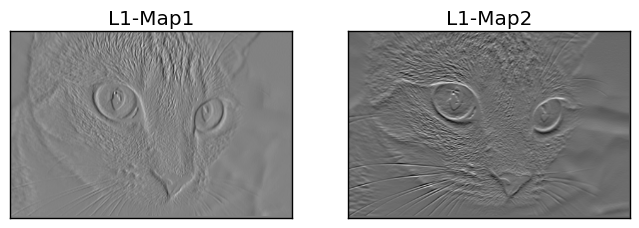

In [70]:
class CNN(Node):
    def __init__(self, conv_in, filters):
        Node.__init__(self, [conv_in, filters])
        self.conv_in = conv_in
        self.filters = filters
    
    def forward(self):
        (n_f, n_c_f, f, _) = self.filters.shape # filter dimensions
        n_c, in_dim, _ = self.conv_in.shape # image dimensions
    
        out_dim = int((in_dim - f)/s)+1 # calculate output dimensions
    
        assert n_c == n_c_f, "Dimensions of filter must match dimensions of input image"
    
        out = np.zeros((n_f,out_dim,out_dim))
    
        # convolve the filter over every part of the image, adding the bias at each step. 
        for curr_f in range(n_f):
            curr_y = out_y = 0
            while curr_y + f <= in_dim:
                curr_x = out_x = 0
                while curr_x + f <= in_dim:
                    out[curr_f, out_y, out_x] = np.sum(filt[curr_f] * image[:,curr_y:curr_y+f, curr_x:curr_x+f]) + bias[curr_f]
                    curr_x += s
                    out_x += 1
                curr_y += s
                out_y += 1
                
        self.value = out
    
    
    def backward(self):
        '''
        Backpropagation through a convolutional layer. 
        '''
        (n_f, n_c, f, _) = self.filters.shape
        (_, orig_dim, _) = self.conv_in.shape
        ## initialize derivatives
        dout = np.zeros(conv_in.shape) 
        dfilt = np.zeros(filt.shape)
        dbias = np.zeros((n_f,1))
        for curr_f in range(n_f):
            # loop through all filters
            curr_y = out_y = 0
            while curr_y + f <= orig_dim:
                curr_x = out_x = 0
                while curr_x + f <= orig_dim:
                    # loss gradient of filter (used to update the filter)
                    dfilt[curr_f] += dconv_prev[curr_f, out_y, out_x] * conv_in[:, curr_y:curr_y+f, curr_x:curr_x+f]
                    # loss gradient of the input to the convolution operation (conv1 in the case of this network)
                    dout[:, curr_y:curr_y+f, curr_x:curr_x+f] += dconv_prev[curr_f, out_y, out_x] * filt[curr_f] 
                    curr_x += s
                    out_x += 1
                curr_y += s
                out_y += 1
            # loss gradient of the bias
            dbias[curr_f] = np.sum(dconv_prev[curr_f])
            
        #  we have d-of-out, d-of-filt, d-of-bias
        ## todo : add gradients